In [1]:
from ema_workbench import (
    Model,
    MultiprocessingEvaluator,
    SequentialEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario,
    Policy,
    save_results,
    load_results,
)
from ema_workbench.util import ema_logging

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [2]:
import copy
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

In [3]:
results_v0 = pd.read_csv("directed search results/dike_model_policy_design.csv",index_col=0)
results_v1 = pd.read_csv("directed search results/dike_model_policy_design_big_nfe.csv",index_col=0)

In [3]:
model, steps = get_model_for_problem_formulation(2)

### Re-evaluating Candidate Solutions under different scenarios

- Filtering policies based on hard constraints.
    - Expected Number of Deaths < 0.001
    - At least one Rfr project i.e. sum(Rfr) >=1
    - Expected Annual Damage < 0.01

In [17]:
results_v0.columns

Index(['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2',
       '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2',
       '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'Expected Annual Damage', 'Dike Investment Costs',
       'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths',
       'Total Investment Costs'],
      dtype='object')

In [18]:
logical_1 = results_v0['Expected Number of Deaths']<0.001
results_v0['RfR_agg']=results_v0.iloc[:,0:15].agg(['sum'],axis="columns")
logical_2 = results_v0['RfR_agg']>=1
logical_3 = results_v0['Expected Annual Damage']<0.01

In [19]:
logical_11 = results_v1['Expected Number of Deaths']<0.001
results_v1['RfR_agg']=results_v1.iloc[:,0:15].agg(['sum'],axis="columns")
logical_21 = results_v1['RfR_agg']>=1
logical_31 = results_v1['Expected Annual Damage']<0.01

In [25]:
policies = pd.concat([results_v0[logical_1 & logical_2 & logical_3],results_v1[logical_11 & logical_21 & logical_31]])
policies.to_csv("Filtered Policies - to be tested for robustness.csv")

In [20]:
policies = pd.concat([results_v0[logical_1 & logical_2 & logical_3],results_v1[logical_11 & logical_21 & logical_31]])
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies = policies.drop(columns=['RfR_agg'])
policies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 118 to 174
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   0_RfR 0             6 non-null      int64
 1   0_RfR 1             6 non-null      int64
 2   0_RfR 2             6 non-null      int64
 3   1_RfR 0             6 non-null      int64
 4   1_RfR 1             6 non-null      int64
 5   1_RfR 2             6 non-null      int64
 6   2_RfR 0             6 non-null      int64
 7   2_RfR 1             6 non-null      int64
 8   2_RfR 2             6 non-null      int64
 9   3_RfR 0             6 non-null      int64
 10  3_RfR 1             6 non-null      int64
 11  3_RfR 2             6 non-null      int64
 12  4_RfR 0             6 non-null      int64
 13  4_RfR 1             6 non-null      int64
 14  4_RfR 2             6 non-null      int64
 15  EWS_DaysToThreat    6 non-null      int64
 16  A.1_DikeIncrease 0  6 non-null      int64
 17  A.

In [21]:
policies_to_evaluate = []
for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [22]:
len(policies_to_evaluate)

6

In [45]:
print(f"Evaluating {len(policies_to_evaluate)} policies across {n_scenarios} scenarios")

Evaluating 6 policies across 10 scenarios


In [42]:
n_scenarios = 10
#with MultiprocessingEvaluator(model) as evaluator:
with SequentialEvaluator(model) as evaluator:
    scenario_results = evaluator.perform_experiments(n_scenarios,policies_to_evaluate)

100%|██████████████████████████████████████████| 60/60 [03:37<00:00,  3.63s/it]


In [48]:
save_results(scenario_results, "directed search results/policy_robustness_1000_scenarios.tar.gz")

### Calculating Signal to Noise Ratio

In [4]:
scenario_results=load_results("directed search results/policy_robustness_1000_scenarios.tar.gz")

In [5]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [6]:
experiments, outcomes = scenario_results
np.unique(experiments['policy'])

array([  0,  24,  50,  86, 118, 174], dtype=int64)

In [7]:
experiments, outcomes = scenario_results
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Investment Costs
0,5.444690e+17,9.157514,0.0,1.834841e+08,0.004660,3.667883e+12
24,4.277598e+17,0.000000,0.0,8.791543e+07,0.005209,2.538514e+12
50,4.767650e+17,3.393628,0.0,2.095274e+08,0.004113,3.961376e+12
86,4.829870e+17,1.621477,0.0,2.462617e+08,0.004743,6.739248e+12
118,4.657078e+17,5.932523,0.0,7.522920e+07,0.003115,2.622015e+12
174,4.745667e+17,2.582301,0.0,1.383329e+08,0.006781,5.683154e+12


In [8]:
ooi=scores.columns.tolist()

In [18]:
help(paraxes.plot)

Help on method plot in module ema_workbench.analysis.parcoords:

plot(data, color=None, label=None, **kwargs) method of ema_workbench.analysis.parcoords.ParallelAxes instance
    plot data on parallel axes
    
    Parameters
    ----------
    data : DataFrame or Series
    color : valid mpl color, optional
    label : str, optional
    
    any additional kwargs will be passed to matplotlib's plot
    method.
    
    Data is normalized using the limits specified when initializing
    ParallelAxis.



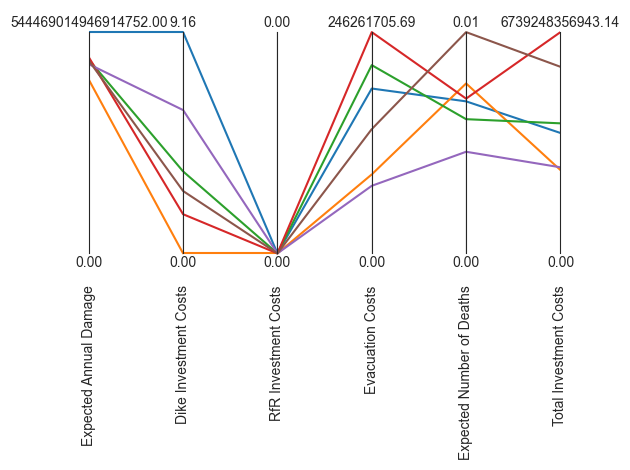

In [25]:
from ema_workbench.analysis import parcoords

data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ooi] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=10)
paraxes.plot(data)
plt.savefig("directed search results/parcoord for SNR plot.png")
plt.show()


## Calculating regret

In [26]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [27]:
experiments, outcomes = scenario_results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    

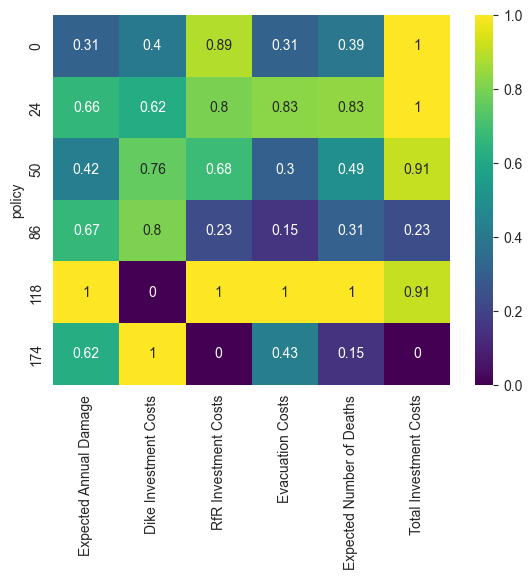

In [28]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.savefig("directed search results/heatmap for max regret plot.png", bbox_inches='tight')
plt.show()

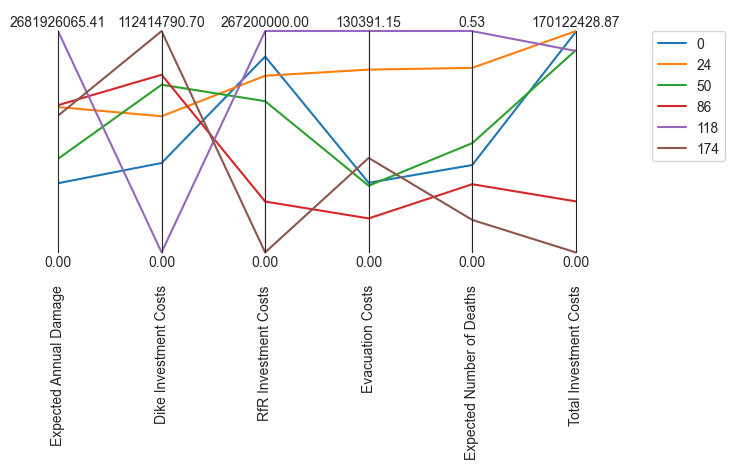

In [30]:

colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, ooi] = 0

paraxes = parcoords.ParallelAxes(limits,fontsize=10)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()

plt.savefig("directed search results/parcoord for regret plot.png")
plt.show()

In [31]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

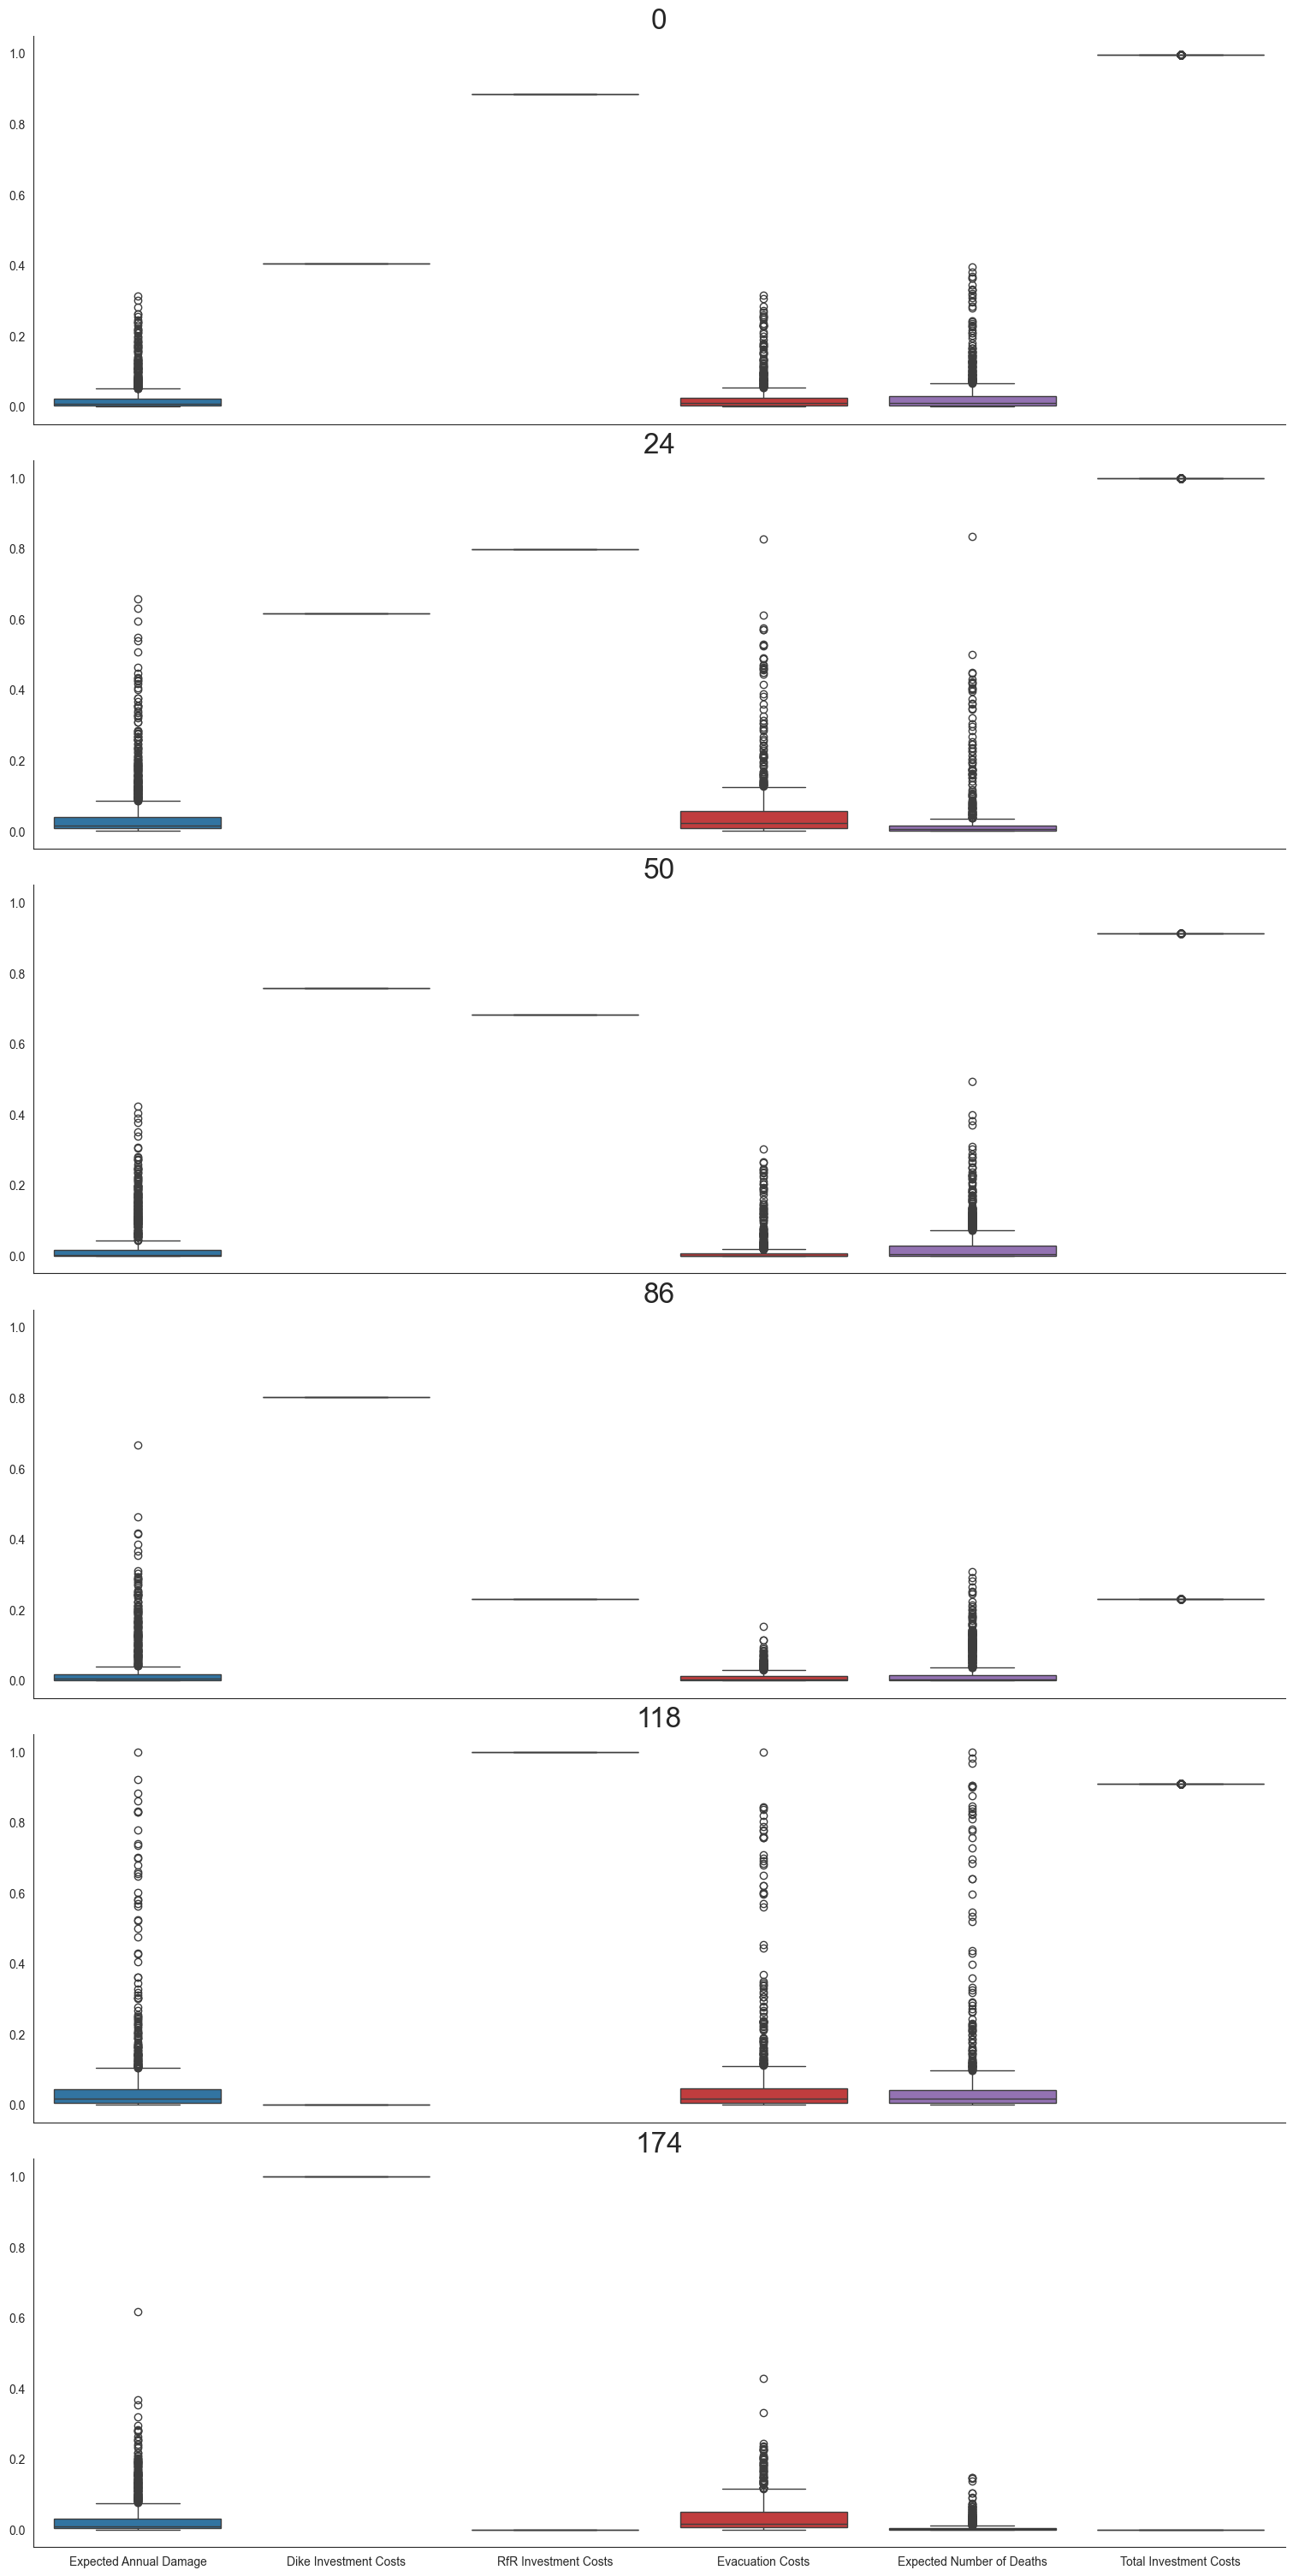

In [39]:
# this generates a 2 plots with a shared y and x axis
fig, axes = plt.subplots( nrows=6, figsize=(15,30), 
                         sharey=True, sharex=True,constrained_layout=True)
#axes.flatten()

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 


# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy),fontsize=24)


plt.savefig("directed search results/boxplot for regret.png")
plt.show()

## Scenario Discovery
Under which conditions do these policies result in poor performance?